# Commute time to Amsterdam Central

The goal is to get some understanding of the commute times by public transport to Amsterdam Central. We will be using the Google distance matrics API and plotly for visualization.

---


Load my google API key and init the client. ([Distance Matrics API](https://developers.google.com/maps/documentation/distance-matrix/overview?hl=en_GB), [Python client](https://github.com/googlemaps/google-maps-services-python) for instructions)

In [1]:
import googlemaps

with open('./maps.key') as f:
    key = f.readline()
    
gmaps = googlemaps.Client(key=key)

Define reference/target location. In our case Amsterdam Central

In [2]:
from types import SimpleNamespace

dest = SimpleNamespace()
dest.geocode = gmaps.geocode('Amsterdam Centraal Train Station')
dest.location = dest.geocode[0]['geometry']['location']
dest.lat, dest.lon = float(dest.location['lat']), float(dest.location['lng'])
dest.str_coords = f"{dest.lat},{dest.lon}"

Generate a uniformly sampled grid around the target. Take into account maximum request size, thus create batches with 100 origin locations each.

In [3]:
import numpy as np

batches = []
for batch_nr in range(100):
    origins = []
    lat_list = []
    lon_list = []
    for __ in range(100):
        origin_lat = dest.lat + np.random.uniform(-0.6, 0.6)
        origin_lon = dest.lon + np.random.uniform(-0.6, 0.6)
        
        lat_list.append(origin_lat)
        lon_list.append(origin_lon)
        origins.append(f"{origin_lat},{origin_lon}")
        
    batches.append([origins, lat_list, lon_list])

Request the commute time in transit on a Tuesday morning at 9. Extract the time from the request convert to minutes and create a DataFrame.

In [5]:
import pandas as pd
from datetime import datetime

dfs = []
for origins, lat_list, lon_list in batches:
    
    # Tuesday the 1st of september 9 am
    dep_time = datetime(2020, 9, 1, 9)
    
    # Get the result of the request for transit at the specified time
    result = gmaps.distance_matrix(origins, dest.str_coords, mode='transit', departure_time=dep_time)
    
    # Make sure to filter out the bad requests
    time = [elm['elements'][0]['duration']['value'] if elm['elements'][0]['status'] == 'OK' else np.NaN for elm in result['rows']]
    
    # Convert the seconds to minutes
    time = [elm/60 for elm in time]
    
    df = pd.DataFrame({'Latitude': lat_list, 'Longitude': lon_list, 'Time [min]': time})
    
    dfs.append(df)

As a request with costs 5 USD per 1000 elements we save the concatenated result. 

In [6]:
df = pd.concat(dfs)
df.to_csv('output_week_9am.csv')
df = pd.read_csv('output_week_9am.csv')
df = df.dropna()

Visualize using plotly, how convenient.

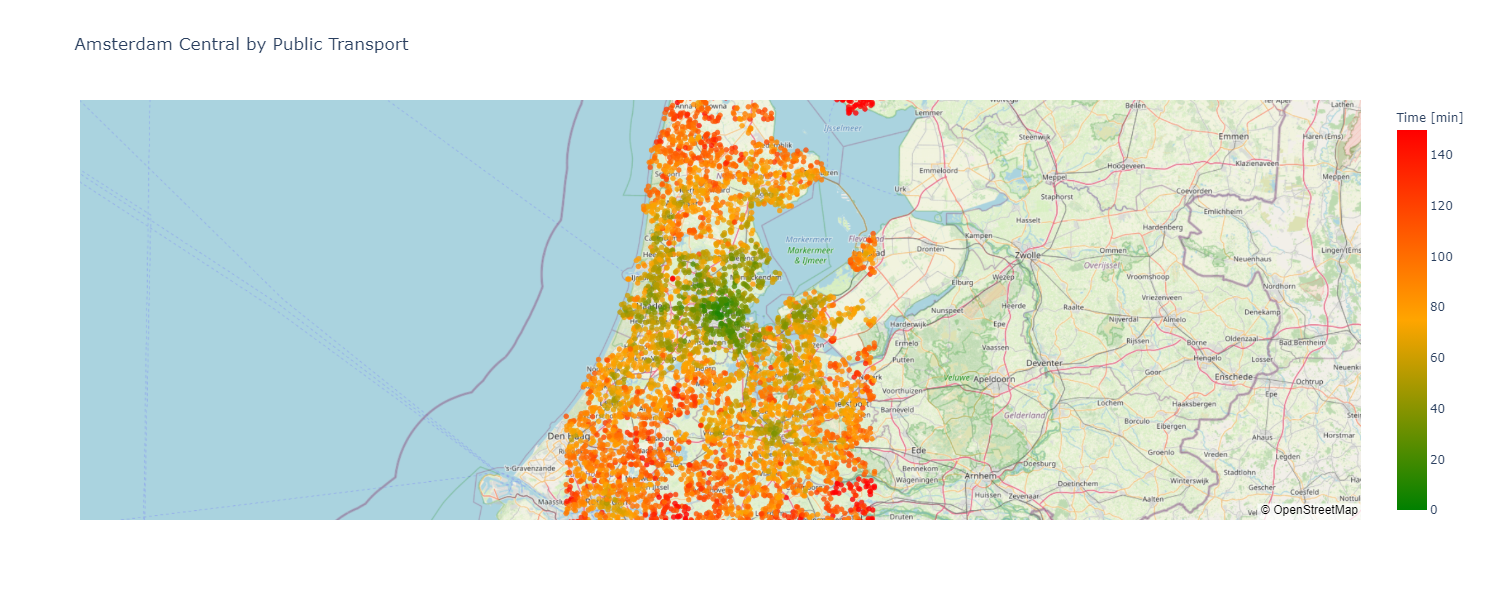

In [18]:
import plotly.express as px
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', color='Time [min]',
                        center=dict(lat=dest.lat, lon=dest.lon), zoom=7.5, opacity=0.8,
                        color_continuous_scale=["green", "orange", "red"], range_color=[0, 150],
                        title='Amsterdam Central by Public Transport', 
                        mapbox_style="open-street-map", width=800, height=600)
fig.write_html('visual.html')
fig.show()